# Amazon Reviews for Sentiment Analysis

A few million Amazon reviews in fastText format
DataSet from https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import nltk
import random
import string
lemmatize=nltk.WordNetLemmatizer()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [3]:
from tqdm import tqdm
import bz2

In [4]:
from collections import Counter
from wordcloud import WordCloud

## Import Data

In [5]:
train_file = bz2.BZ2File('../train.ft.txt.bz2')
test_file = bz2.BZ2File('../test.ft.txt.bz2')

In [6]:
train_lines = train_file.readlines()
test_lines = test_file.readlines()

In [7]:
train_lines = [x.decode('utf-8') for x in train_lines]
test_lines = [x.decode('utf-8') for x in test_lines]

In [8]:
train_lines[0].split(' ')[0]

'__label__2'

In [9]:
' '.join(train_lines[0].split(' ')[1:])

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [10]:
train_label = ["negative" if x.split(' ')[0] == '__label__1' else "positive" for x in train_lines ]
len(train_label)

3600000

In [11]:
train_content = [' '.join(x.split(' ')[1:]) for x in train_lines ]
len(train_content)

3600000

In [12]:
train_content[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [13]:
data = pd.DataFrame(list(zip(train_label, train_content)), columns =['label', 'content'])
data.sample(5)

,label,content
2610969,positive,An exquisitely photographed appitite inducing ...
342464,positive,push it: I have been a fan for years...I purch...
1628608,negative,Don't believe the hype: Martin Scorsese once s...
2262177,negative,someone else should have wrote this: A great t...
1269671,negative,The Mystery Is Solved: My family drinks a lot ...


In [14]:
data.isna().sum()

label      0
content    0
dtype: int64

In [15]:
data.duplicated().sum()

0

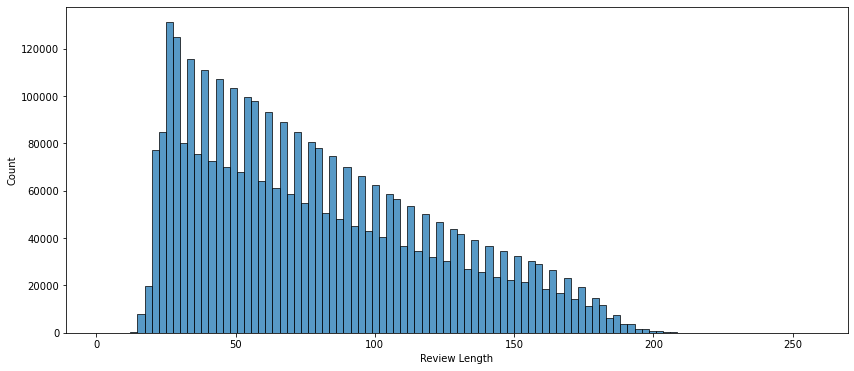

In [16]:
#words per review
plt.figure(figsize = (14,6))
WordsPerReview = data['content'].apply(lambda x: len(x.split(' ')))

sns.histplot(WordsPerReview,bins = 100)

plt.xlabel('Review Length')
plt.show()

<AxesSubplot:xlabel='reviewLength'>

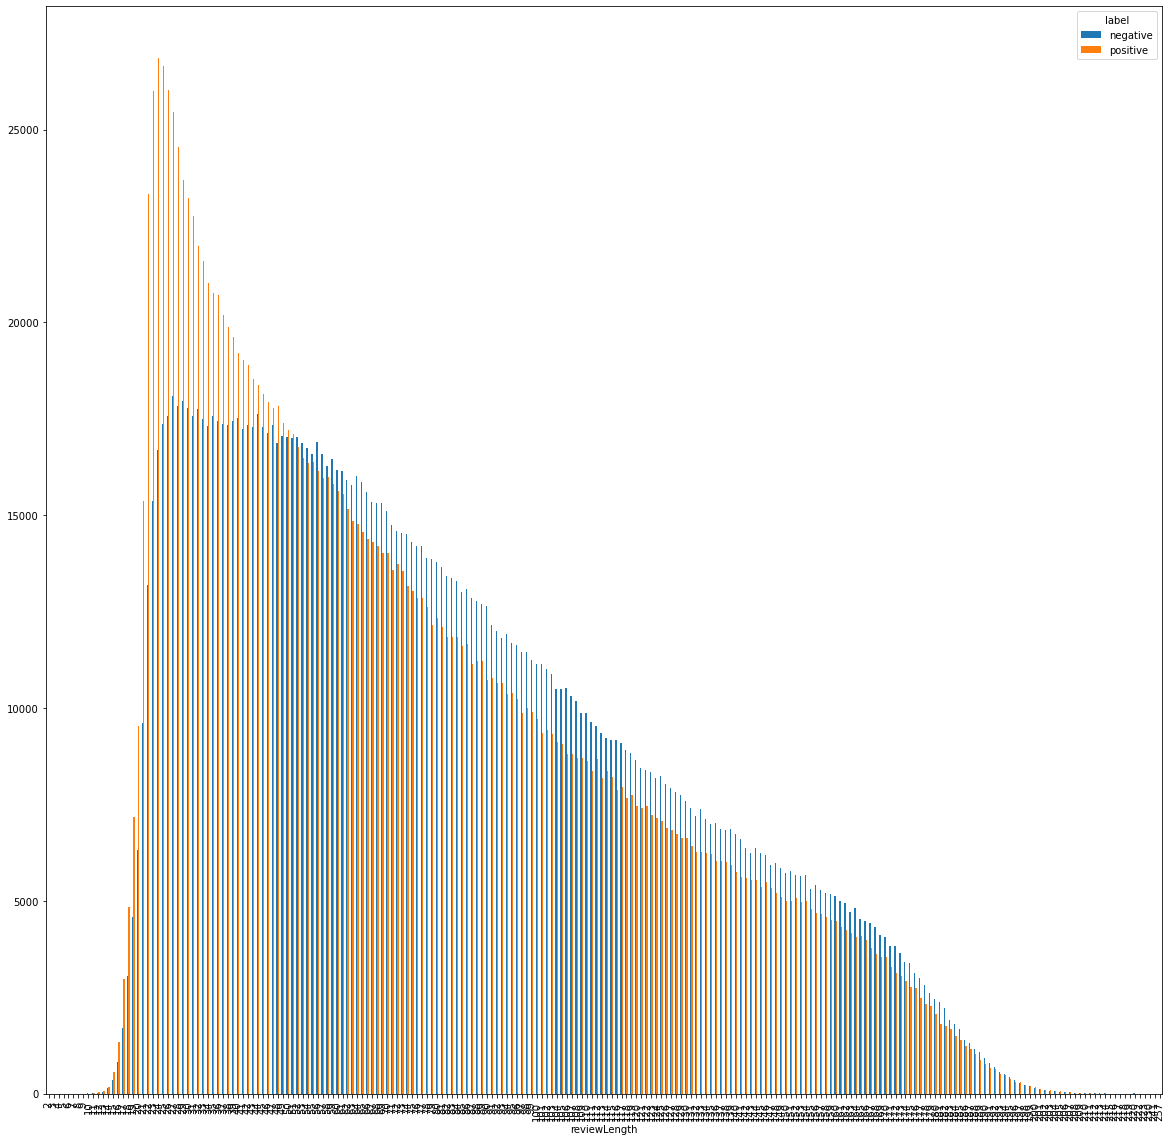

In [25]:
data['reviewLength'] = WordsPerReview
Amazon_sentiment = data.groupby(['reviewLength', 'label']).label.count().unstack()
Amazon_sentiment.plot(kind='bar',figsize=(20,20))

In [26]:
data['label'].value_counts()

negative    1800000
positive    1800000
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

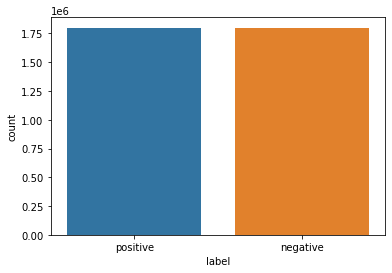

In [27]:
sns.countplot(x=data['label'])

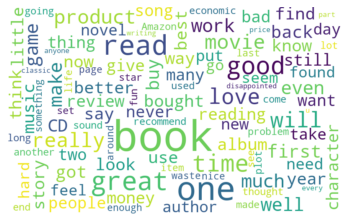

In [28]:
txt = ' '.join(review for review in data.content[0:2000])

wordcloud = WordCloud(
            background_color = 'white',
            max_font_size = 100,
            max_words = 100,
            width = 800,
            height = 500
            ).generate(txt)


plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Clean Text

In [29]:
import re 
def clean_text(Review):
   
    Review = str(Review).lower() # convert to lowercase
    Review = re.sub('\[.*?\]', '', Review) 
    Review = re.sub('https?://\S+|www\.\S+', '', Review) # Remove URls
    Review = re.sub('<.*?>+', '', Review)
    Review = re.sub(r'[^a-z0-9\s]', '', Review) # Remove punctuation
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review

In [30]:
data['cleanContent'] = data['content'].apply(clean_text)

In [31]:
data.head()

,label,content,reviewLength,cleanContent
0,positive,Stuning even for the non-gamer: This sound tra...,80,stuning even for the nongamer this sound track...
1,positive,The best soundtrack ever to anything.: I'm rea...,97,the best soundtrack ever to anything im readin...
2,positive,Amazing!: This soundtrack is my favorite music...,129,amazing this soundtrack is my favorite music o...
3,positive,Excellent Soundtrack: I truly like this soundt...,118,excellent soundtrack i truly like this soundtr...
4,positive,"Remember, Pull Your Jaw Off The Floor After He...",87,remember pull your jaw off the floor after hea...


In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\MSI
[nltk_data]     I7\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [42]:
stop_words = set(stopwords.words('english'))
stopword = []
from nltk import word_tokenize


#words = nltk.word_tokenize(sentence)


def remove_stopword(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

data['reviews_text'] = data['cleanContent'].apply(lambda row: remove_stopword(stop_words, row))


KeyboardInterrupt: 

In [44]:
data['reviews_text'] = data['reviews_text'].apply(lambda row: ' '.join(row))
data.head()

,label,content,reviewLength,cleanContent,reviews_text
0,positive,Stuning even for the non-gamer: This sound tra...,80,stuning even for the nongamer this sound track...,stuning even nongamer sound track beautiful pa...
1,positive,The best soundtrack ever to anything.: I'm rea...,97,the best soundtrack ever to anything im readin...,best soundtrack ever anything im reading lot r...
2,positive,Amazing!: This soundtrack is my favorite music...,129,amazing this soundtrack is my favorite music o...,amazing soundtrack favorite music time hands i...
3,positive,Excellent Soundtrack: I truly like this soundt...,118,excellent soundtrack i truly like this soundtr...,excellent soundtrack truly like soundtrack enj...
4,positive,"Remember, Pull Your Jaw Off The Floor After He...",87,remember pull your jaw off the floor after hea...,remember pull jaw floor hearing youve played g...


In [45]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(data['reviews_text'], data['label'], test_size=0.2)

print(len(text_train), len(text_test), len(text_train) + len(text_test))

2880000 720000 3600000


In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
clf = Pipeline([
    ('vect', CountVectorizer(stop_words= "english")),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
    ])

In [47]:
fit_model = clf.fit(text_train,label_train)

In [48]:
y_pred = clf.predict(text_test)

In [49]:
print('Training accuracy:', fit_model.score(text_train,label_train))
print('Test accuracy:', fit_model.score(text_test,label_test))

Training accuracy: 0.8625875
Test accuracy: 0.8428638888888889


In [50]:
from sklearn.metrics import confusion_matrix
print(classification_report(label_test,y_pred))

print(confusion_matrix(label_test,y_pred))

              precision    recall  f1-score   support

    negative       0.84      0.85      0.84    359472
    positive       0.85      0.83      0.84    360528

    accuracy                           0.84    720000
   macro avg       0.84      0.84      0.84    720000
weighted avg       0.84      0.84      0.84    720000

[[306731  52741]
 [ 60397 300131]]
